In [60]:
from __future__ import absolute_import, division, print_function

import keras
from keras.layers import Dense, Flatten, Dropout, Lambda, Activation
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D,BatchNormalization
from keras import regularizers
from keras import layers
from keras.models import Sequential,load_model
from keras import backend as K
from keras.callbacks import *
from keras.initializers import glorot_normal
from keras.optimizers import SGD, Adam
from keras.constraints import max_norm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

import numpy as np
from scipy import fftpack
from scipy import ndimage

from IPython.display import clear_output
from matplotlib import pyplot as plt

import cv2

import pickle
import os.path
import sys
import zipfile

sys.path.append('..')
from defectfinder import gridsearch as gs

In [4]:
gs.detectGPU()

----Available GPUs(if GPU is detected, the code will automatically run on GPU)----
['/job:localhost/replica:0/task:0/device:GPU:0']
----Devices imformation----
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7374613847495953651
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11272526234
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15713268506904358356
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
# unzip the dataset and load
zip_ref=zipfile.ZipFile(".././dataset/dataset_noise.zip",'r')
zip_ref.extractall(".././dataset")
zip_ref.close()

In [5]:
x_train_origin=np.load(".././dataset/dataset_noise/x_train.npy")
x_test_origin=np.load(".././dataset/dataset_noise/x_test.npy")
y_train_origin=np.load(".././dataset/dataset_noise/y_train.npy")
y_test_origin=np.load(".././dataset/dataset_noise/y_test.npy")

In [6]:
# make it center to 0, and the standarddeviation is 1
x_train=(x_train_origin-np.mean(x_train_origin))/np.std(x_train_origin)
x_test=(x_test_origin-np.mean(x_train_origin))/np.std(x_train_origin)

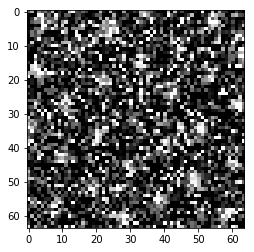

In [7]:
plt.imshow(np.reshape(x_train[752],(64,64)),cmap='gray')

## Test the model
* At first we use only a small amount of data to test the model. The accuracy of a good model is expected to be 1.00 (Though the validation accuracy maybe very low)

In [26]:
num_classes = 6

# input image dimensions
img_x, img_y = 64, 64
input_shape = (img_x, img_y, 1)

In [54]:
#At beginning only use very few training data
x_train_sample,y_train_sample=resample(x_train_origin,y_train_origin,n_samples=60,replace=False)
x_test_sample,y_test_sample=resample(x_test_origin,y_test_origin,n_samples=20,replace=False)

x_train_sample=(x_train_sample-np.mean(x_train_sample))/np.std(x_train_sample)
x_test_sample=(x_test_sample-np.mean(x_train_sample))/np.std(x_train_sample)

* May need to upgrade to the latest version of tensorflow when use "get_model()"

In [32]:
#model=gridsearch.get_model(0.01) #learning rate=0.01

In [33]:
plot = gs.PlotLearning()

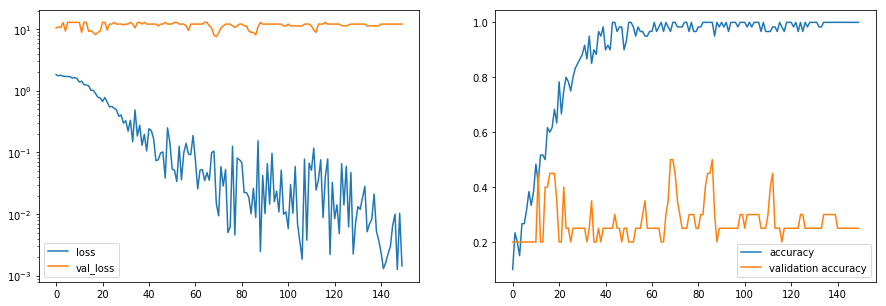

In [68]:
model.fit(x_train_sample,y_train_sample,
         batch_size=16,
         epochs=150,
         verbose=1,
         validation_data=(x_test_sample,y_test_sample),
         callbacks=[plot])

## Grid Search
* Randomly search learning rate from 1e-5 to 1

In [69]:
np.random.seed(304)

learn_rate=(10**np.random.uniform(-5,0,15)).tolist() 
# this the list of learning rate you want to search

sgd_momentum=np.random.uniform(0,1,3).tolist()

batch_size=128
epochs=150

In [71]:
def get_model2(learn_rate,sgd_momentum):

    '''
    get keras convolutional neural network model with given learning rate

    Arguments:learning rate

    Returns:keras model

    Raises:Error if the input is not a float.

    '''

    assert type(learn_rate)==float,"learning rate must be a float"
    assert type(sgd_momentum)==float,"momentum must be a float"
    
    model = Sequential()

    ##### add layers to CNN model: 
    #model.add(Conv2D(8,kernel_size=(7,7),use_bias=False,strides=(1,1),
    #               input_shape=(64,64,1),kernel_initializer="glorot_normal"))
    #padding = 'same'
    model.add(Conv2D(8,kernel_size=(5,5),use_bias=False,strides=(1,1),
                     input_shape=(64,64,1),kernel_initializer="glorot_normal"))
    model.add(Conv2D(16,kernel_size=(5,5),use_bias=False,strides=(1,1),
                     input_shape=(64,64,1),kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(32,(5,5),use_bias=False,kernel_initializer="glorot_normal"))
    #model.add(Conv2D(16,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(64,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.20))
    
    model.add(Conv2D(128,(3,3),use_bias=False,kernel_initializer="glorot_normal"))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.20))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.20))
    model.add(Dense(6))
    BatchNormalization(axis=1, momentum=0.99,epsilon=0.001,center=True)
    model.add(Activation("softmax"))
    
    #sgd = SGD(lr=learn_rate,momentum=sgd_momentum)
    adam= Adam(lr=learn_rate)
    model.compile(loss = 'categorical_crossentropy',optimizer = adam, metrics=['accuracy'])
    return model


In [72]:
model=get_model2(0.001,0.9)

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_244 (Conv2D)          (None, 60, 60, 8)         200       
_________________________________________________________________
conv2d_245 (Conv2D)          (None, 56, 56, 16)        3200      
_________________________________________________________________
activation_247 (Activation)  (None, 56, 56, 16)        0         
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 28, 28, 16)        0         
_________________________________________________________________
dropout_59 (Dropout)         (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_246 (Conv2D)          (None, 24, 24, 32)        12800     
_________________________________________________________________
activation_248 (Activation)  (None, 24, 24, 32)        0         
__________

In [76]:
learn_rate

[0.0012124478608052265,
 0.14065898274722327,
 0.4970479001357962,
 0.0011132905970441058,
 0.0005437384201377625,
 0.00111245571558223,
 0.010292057196606396,
 0.282838650784522,
 0.24036631698188757,
 8.120783460079087e-05,
 8.788437862948488e-05,
 1.787798599113689e-05,
 0.0026247429176293924,
 0.045978480262674426,
 0.022306480345392014]

In [74]:
def gridsearch(x_train,y_train_origin,learn_rate,sgd_momentum,batch_size,epochs,filename):

    '''
    given the training dataset, it will be randomly split into training and validation set
    and the keras model will be trained with given learn_rate, batch size and epochs

    Arguments:
    x_train: x training dataset, need to be centered

    y_train_origin: y training dataset, needless to be centered

    learn_rate: a list of learning rate

    batchsize: a int

    epochs: a int

    Returns:
    fitresult: a list, each element is a keras history object
    models_grid: a list, each element is a trained model

    every model, training history model_weights will be saved in a folder named learnrate

    Raises:
    error if the shape of x or y is wrong

    ''' 
    assert np.shape(x_train)[1:4]==(64, 64, 1),"the expected shape of x_train is (channels,img_x,img_y,1)"
    
    assert np.shape(y_train_origin)[1]==6,"the expected shape of y_train is (channels,6)"

    #create a new directory to save all the training history and model_weights
    version=1
    while os.path.exists('../HyperparametersTuning/'+filename+str(version)):
        version=version+1
    os.makedirs('../HyperparametersTuning/'+filename+str(version))
    
    search_grid=[(learn_rate[i],sgd_momentum[j]) 
                 for i in range(len(learn_rate)) for j in range(len(sgd_momentum))]

    fitresult=[] #list save history of each keras model
    models_grid=[get_model2(learn_rate[0],sgd_momentum[0])]*len(search_grid) #list save each keras model
    
    for i in range(len(search_grid)):
        #randomly split the training data into training set and validation set
        x_tra,x_val,y_tra,y_val=train_test_split(x_train,y_train_origin,test_size=0.33)
        models_grid[i]=get_model2(search_grid[i][0],search_grid[i][1])
        fitresult.append(models_grid[i].fit(x_tra,y_tra,
                                            batch_size=batch_size,
                                            epochs=epochs,
                                            verbose=1,
                                            validation_data=(x_val,y_val),shuffle=True))  
    
    with open('../HyperparametersTuning/'+filename+str(version)+"/search_grid.txt","wb") as fp:
        pickle.dump(search_grid,fp)
    
    for i in range(len(fitresult)):
        #save history of each model
        with open('../HyperparametersTuning/'+filename+str(version)+"/fitresult"+str(i)+".txt","wb") as fp:
            pickle.dump(fitresult[i].history,fp)
    
        #save each model and weights:
        models_grid[i].save('../HyperparametersTuning/'+filename+str(version)+'/model'+str(i)+'.h5')
        models_grid[i].save_weights('../HyperparametersTuning/'+filename+str(version)+'/model_weight'+str(i)+'.h5')
        
    return fitresult,models_grid,search_grid


In [75]:
# models is a list of models with learning rate from the search list
# result is a list of training history

result,models,search_grid=gridsearch(x_train,y_train_origin,[0.001],[0.9],batch_size,150,
                        "learn_rate0.001_Adam_M2")

Train on 26895 samples, validate on 13247 samples
Epoch 1/150
26895/26895 [==============================] - 9s 349us/step - loss: 0.8258 - acc: 0.6274 - val_loss: 0.4708 - val_acc: 0.7763
Epoch 2/150
26895/26895 [==============================] - 6s 236us/step - loss: 0.4692 - acc: 0.7907 - val_loss: 0.3533 - val_acc: 0.8536
Epoch 3/150
26895/26895 [==============================] - 6s 234us/step - loss: 0.3940 - acc: 0.8281 - val_loss: 0.2957 - val_acc: 0.8808
Epoch 4/150
26895/26895 [==============================] - 6s 237us/step - loss: 0.3514 - acc: 0.8486 - val_loss: 0.2966 - val_acc: 0.8616
Epoch 5/150
26895/26895 [==============================] - 6s 236us/step - loss: 0.3247 - acc: 0.8621 - val_loss: 0.2321 - val_acc: 0.9066
Epoch 6/150
26895/26895 [==============================] - 6s 237us/step - loss: 0.3040 - acc: 0.8731 - val_loss: 0.2439 - val_acc: 0.9015
Epoch 7/150
26895/26895 [==============================] - 6s 237us/step - loss: 0.2944 - acc: 0.8785 - val_loss: 0.

26895/26895 [==============================] - 6s 235us/step - loss: 0.1562 - acc: 0.9410 - val_loss: 0.1211 - val_acc: 0.9536
Epoch 60/150
26895/26895 [==============================] - 6s 236us/step - loss: 0.1506 - acc: 0.9419 - val_loss: 0.1246 - val_acc: 0.9517
Epoch 61/150
26895/26895 [==============================] - 6s 237us/step - loss: 0.1411 - acc: 0.9450 - val_loss: 0.1259 - val_acc: 0.9530
Epoch 62/150
26895/26895 [==============================] - 6s 236us/step - loss: 0.1437 - acc: 0.9431 - val_loss: 0.1337 - val_acc: 0.9496
Epoch 63/150
26895/26895 [==============================] - 6s 237us/step - loss: 0.1465 - acc: 0.9426 - val_loss: 0.1340 - val_acc: 0.9514
Epoch 64/150
26895/26895 [==============================] - 6s 235us/step - loss: 0.1446 - acc: 0.9456 - val_loss: 0.1243 - val_acc: 0.9543
Epoch 65/150
26895/26895 [==============================] - 6s 238us/step - loss: 0.1500 - acc: 0.9416 - val_loss: 0.1319 - val_acc: 0.9518
Epoch 66/150
26895/26895 [=======

26895/26895 [==============================] - 6s 235us/step - loss: 0.1385 - acc: 0.9470 - val_loss: 0.1204 - val_acc: 0.9567
Epoch 118/150
26895/26895 [==============================] - 6s 236us/step - loss: 0.1296 - acc: 0.9512 - val_loss: 0.1103 - val_acc: 0.9579
Epoch 119/150
26895/26895 [==============================] - 6s 234us/step - loss: 0.1244 - acc: 0.9536 - val_loss: 0.1267 - val_acc: 0.9528
Epoch 120/150
26895/26895 [==============================] - 6s 234us/step - loss: 0.1225 - acc: 0.9526 - val_loss: 0.1181 - val_acc: 0.9553
Epoch 121/150
26895/26895 [==============================] - 6s 234us/step - loss: 0.1232 - acc: 0.9534 - val_loss: 0.1129 - val_acc: 0.9572
Epoch 122/150
26895/26895 [==============================] - 6s 236us/step - loss: 0.1230 - acc: 0.9516 - val_loss: 0.1118 - val_acc: 0.9585
Epoch 123/150
26895/26895 [==============================] - 6s 235us/step - loss: 0.1254 - acc: 0.9516 - val_loss: 0.1147 - val_acc: 0.9567
Epoch 124/150
26895/26895 [

KeyboardInterrupt: 

In [115]:
# load previous search result

load_res=gs.load_results(learn_rate,"../HyperparametersTuning/learn_rate1")

In [104]:
def PlotLossAcc(load_res,search_grid):
    for j in range(len(load_res)):
        history=load_res[j]

        fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5),sharex=True)
        ax1.plot(history['acc'])
        ax1.plot(history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        ax1.legend(['train', 'test'], loc='upper left')

        ax2.plot(history['loss'])
        ax2.plot(history['val_loss'])
        plt.title('(LearningRate,momentum) = '+str(search_grid[j]))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        ax2.legend(['train', 'test'], loc='upper left')
        plt.show()

    return

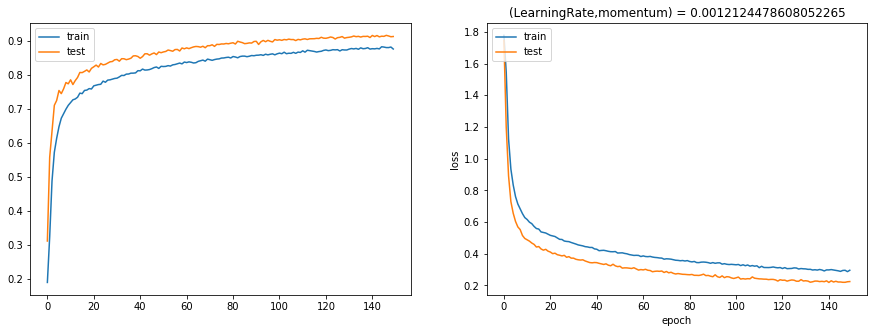

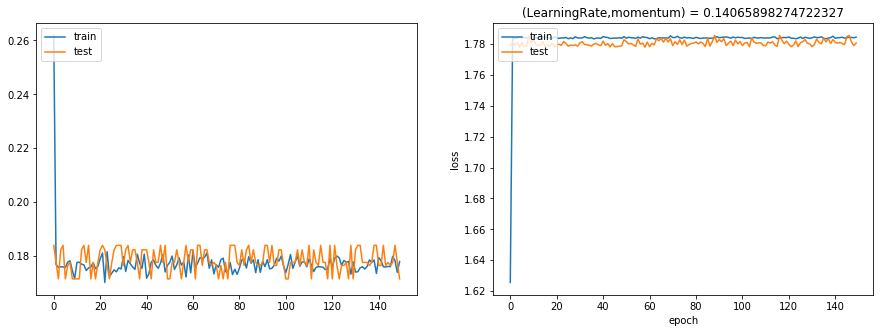

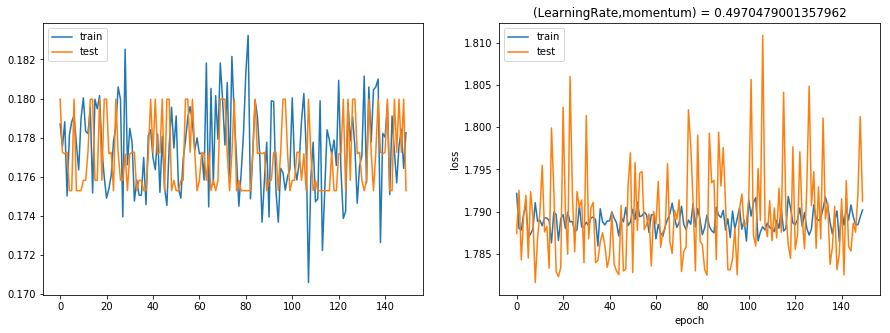

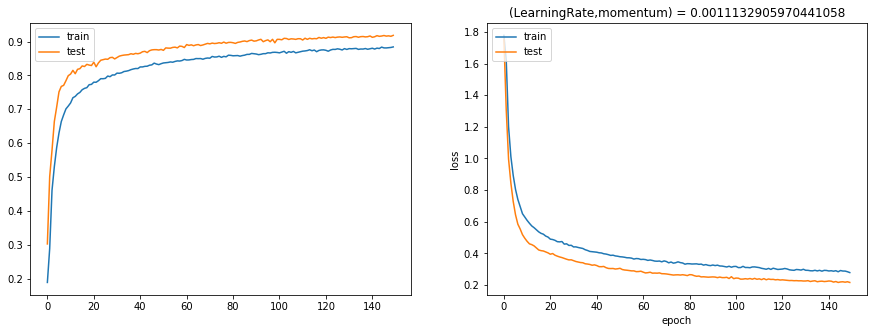

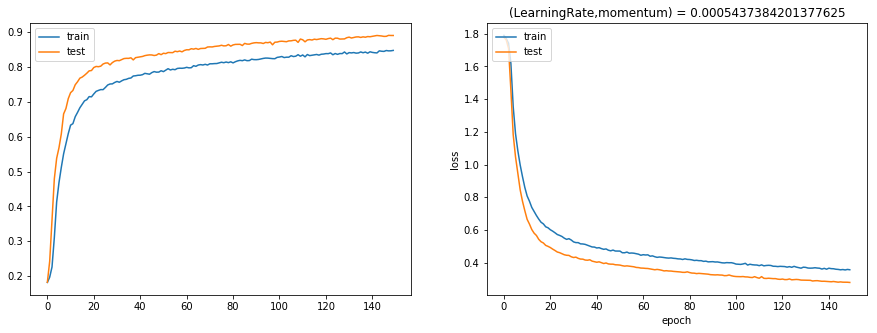

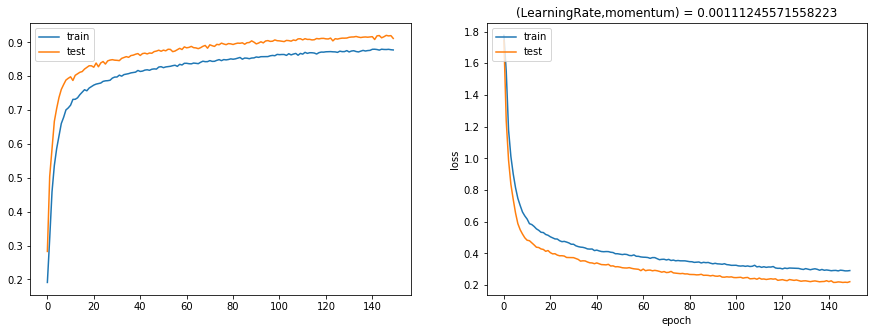

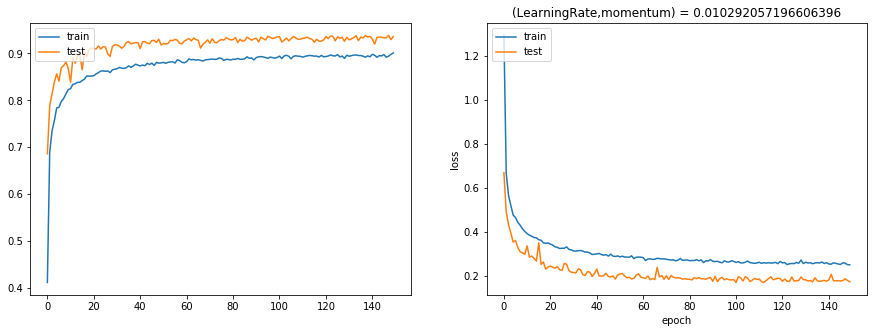

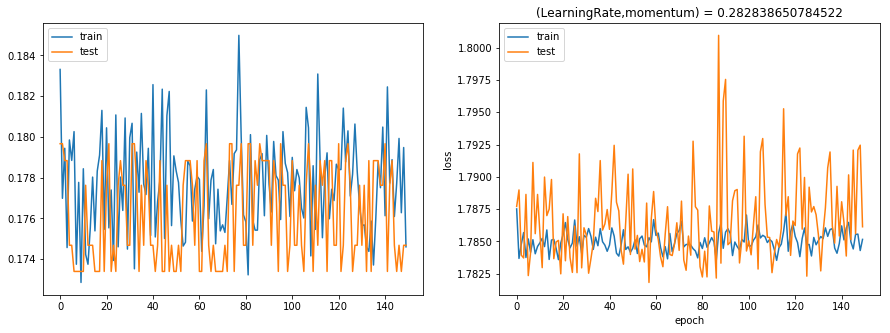

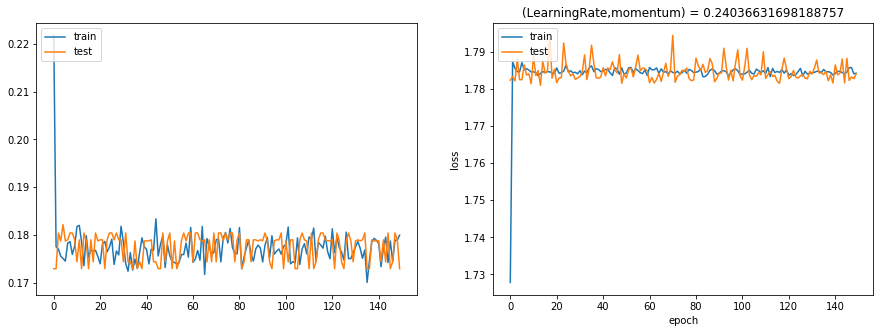

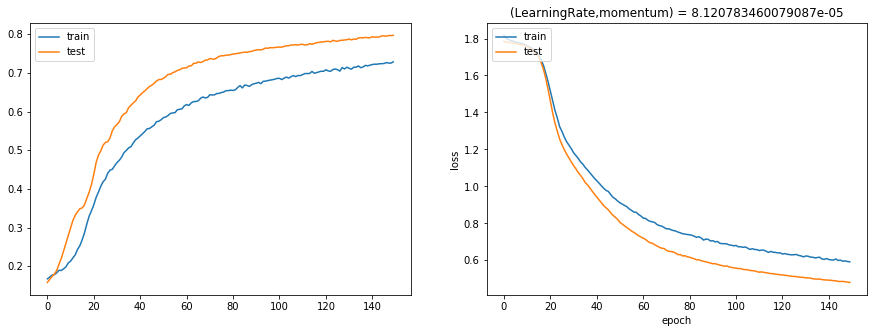

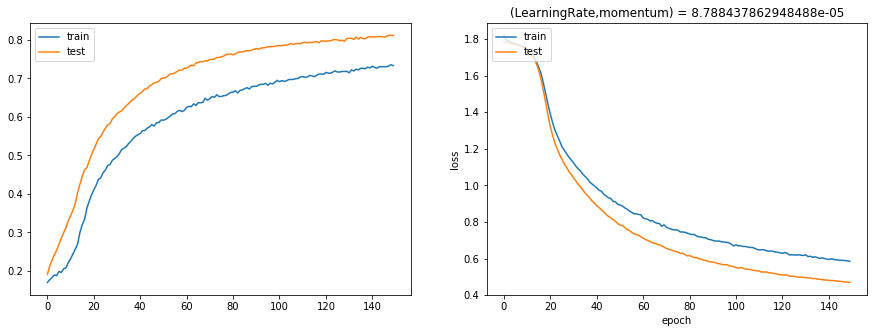

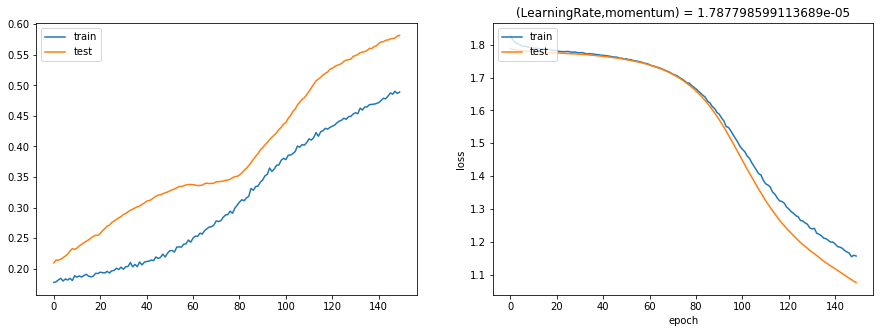

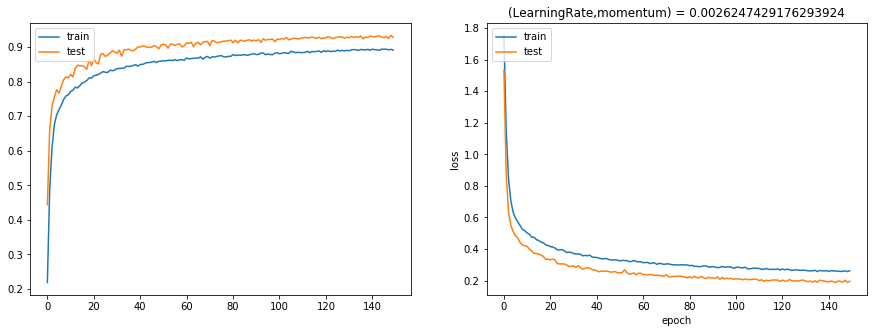

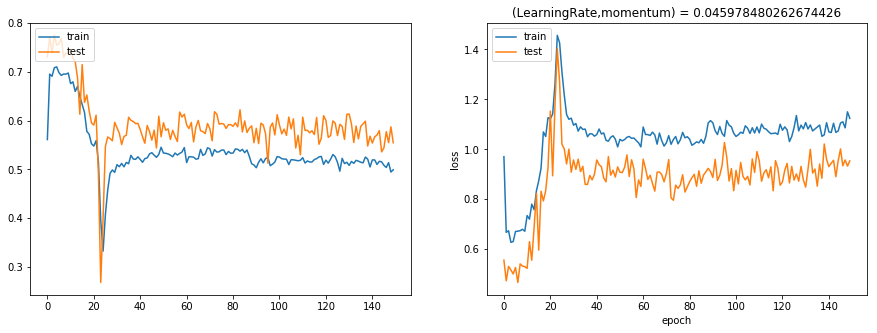

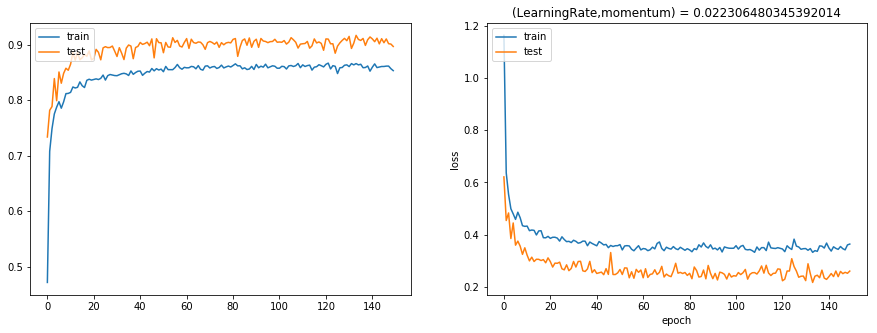

In [116]:
PlotLossAcc(load_res,learn_rate)

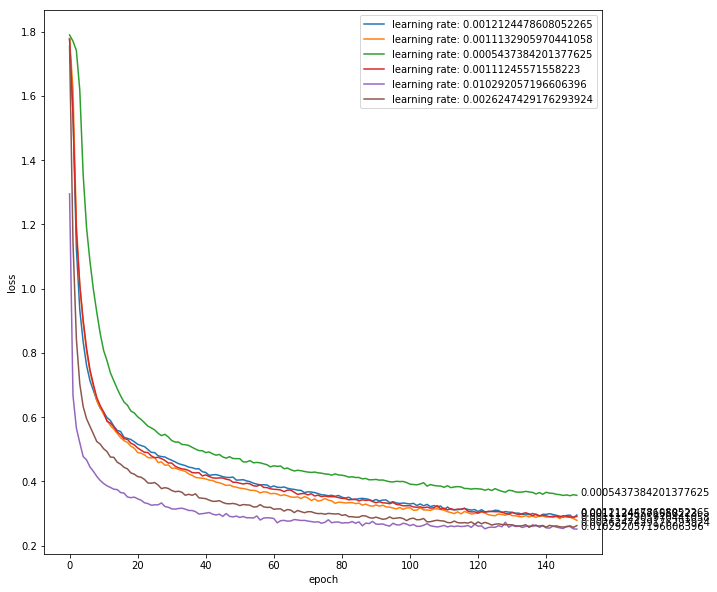

In [44]:
#plot the loss for each model
plt.figure(figsize=(10,10))

for j in range(len(load_res)):
    if(learn_rate[j]>0.0001 and learn_rate[j]<0.02):
        plt.plot(load_res[j]['loss'],label="learning rate: "+str(learn_rate[j]))
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.text(150,load_res[j]['loss'][149],str(learn_rate[j]))
    
plt.legend()

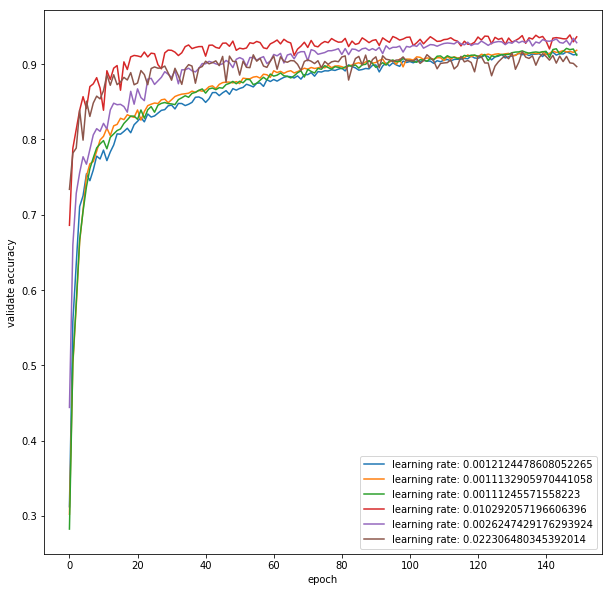

In [84]:
#plot validation accuracy for each model

plt.figure(figsize=(10,10))

for j in range(len(learn_rate)):
    if(learn_rate[j]>0.001 and learn_rate[j]<0.04):
        plt.plot(load_res[j]['val_acc'],label="learning rate: "+str(learn_rate[j]))
        plt.xlabel("epoch")
        plt.ylabel("validate accuracy")
    
plt.legend()

In [101]:
#get the test accuracy of a selected model
select_model=load_model("./learn_rate/model1.h5")

scores=select_model.evaluate(x_test,y_test_origin,verbose=1)

print("%s: %.2f%%" % (select_model.metrics_names[1], scores[1]*100))

10225/10225 [==============================] - 10s 973us/step
acc: 96.57%


## Search Momentum

In [117]:
result,models,search_grid=gridsearch(x_train,y_train_origin,[0.01,0.001],sgd_momentum,batch_size,150,
                        "0.2dropout_momentum")

Train on 26895 samples, validate on 13247 samples
Epoch 1/150
26895/26895 [==============================] - 5s 173us/step - loss: 1.7762 - acc: 0.1941 - val_loss: 1.7483 - val_acc: 0.3297
Epoch 2/150
26895/26895 [==============================] - 3s 117us/step - loss: 1.5935 - acc: 0.2992 - val_loss: 1.2368 - val_acc: 0.5584
Epoch 3/150
26895/26895 [==============================] - 3s 122us/step - loss: 1.1595 - acc: 0.4683 - val_loss: 0.9421 - val_acc: 0.5858
Epoch 4/150
26895/26895 [==============================] - 3s 117us/step - loss: 0.9888 - acc: 0.5390 - val_loss: 0.8681 - val_acc: 0.5956
Epoch 5/150
26895/26895 [==============================] - 3s 118us/step - loss: 0.9023 - acc: 0.5781 - val_loss: 0.7494 - val_acc: 0.7000
Epoch 6/150
26895/26895 [==============================] - 3s 122us/step - loss: 0.8432 - acc: 0.6046 - val_loss: 0.7213 - val_acc: 0.6722
Epoch 7/150
26895/26895 [==============================] - 3s 122us/step - loss: 0.8004 - acc: 0.6294 - val_loss: 0.

26895/26895 [==============================] - 3s 123us/step - loss: 0.3175 - acc: 0.8686 - val_loss: 0.2293 - val_acc: 0.9115
Epoch 118/150
26895/26895 [==============================] - 3s 124us/step - loss: 0.3120 - acc: 0.8717 - val_loss: 0.2307 - val_acc: 0.9112
Epoch 119/150
26895/26895 [==============================] - 3s 123us/step - loss: 0.3174 - acc: 0.8673 - val_loss: 0.2488 - val_acc: 0.8948
Epoch 120/150
26895/26895 [==============================] - 3s 119us/step - loss: 0.3133 - acc: 0.8671 - val_loss: 0.2584 - val_acc: 0.8834
Epoch 121/150
26895/26895 [==============================] - 3s 122us/step - loss: 0.3138 - acc: 0.8703 - val_loss: 0.2337 - val_acc: 0.9064
Epoch 122/150
26895/26895 [==============================] - 3s 122us/step - loss: 0.3173 - acc: 0.8665 - val_loss: 0.2269 - val_acc: 0.9116
Epoch 123/150
26895/26895 [==============================] - 3s 120us/step - loss: 0.3212 - acc: 0.8665 - val_loss: 0.2812 - val_acc: 0.8888
Epoch 124/150
26895/26895 [

26895/26895 [==============================] - 3s 124us/step - loss: 0.4708 - acc: 0.7900 - val_loss: 0.3593 - val_acc: 0.8452
Epoch 26/150
26895/26895 [==============================] - 3s 124us/step - loss: 0.4595 - acc: 0.7942 - val_loss: 0.3524 - val_acc: 0.8525
Epoch 27/150
26895/26895 [==============================] - 3s 124us/step - loss: 0.4586 - acc: 0.7971 - val_loss: 0.3611 - val_acc: 0.8436
Epoch 28/150
26895/26895 [==============================] - 3s 124us/step - loss: 0.4537 - acc: 0.7984 - val_loss: 0.3448 - val_acc: 0.8597
Epoch 29/150
26895/26895 [==============================] - 3s 124us/step - loss: 0.4533 - acc: 0.7999 - val_loss: 0.3407 - val_acc: 0.8579
Epoch 30/150
26895/26895 [==============================] - 3s 122us/step - loss: 0.4459 - acc: 0.8035 - val_loss: 0.3473 - val_acc: 0.8411
Epoch 31/150
26895/26895 [==============================] - 3s 121us/step - loss: 0.4387 - acc: 0.8070 - val_loss: 0.3587 - val_acc: 0.8430
Epoch 32/150
26895/26895 [=======

26895/26895 [==============================] - 3s 122us/step - loss: 0.2924 - acc: 0.8781 - val_loss: 0.2059 - val_acc: 0.9256
Epoch 142/150
26895/26895 [==============================] - 3s 122us/step - loss: 0.2896 - acc: 0.8771 - val_loss: 0.2069 - val_acc: 0.9181
Epoch 143/150
26895/26895 [==============================] - 3s 122us/step - loss: 0.2884 - acc: 0.8817 - val_loss: 0.2066 - val_acc: 0.9169
Epoch 144/150
26895/26895 [==============================] - 3s 123us/step - loss: 0.2919 - acc: 0.8772 - val_loss: 0.2019 - val_acc: 0.9245
Epoch 145/150
26895/26895 [==============================] - 3s 122us/step - loss: 0.2848 - acc: 0.8809 - val_loss: 0.1977 - val_acc: 0.9281
Epoch 146/150
26895/26895 [==============================] - 3s 122us/step - loss: 0.2850 - acc: 0.8806 - val_loss: 0.1978 - val_acc: 0.9259
Epoch 147/150
26895/26895 [==============================] - 3s 124us/step - loss: 0.2866 - acc: 0.8791 - val_loss: 0.2026 - val_acc: 0.9262
Epoch 148/150
26895/26895 [

26895/26895 [==============================] - 3s 117us/step - loss: 0.2591 - acc: 0.8938 - val_loss: 0.2141 - val_acc: 0.9141
Epoch 108/150
26895/26895 [==============================] - 3s 117us/step - loss: 0.2633 - acc: 0.8929 - val_loss: 0.2112 - val_acc: 0.9132
Epoch 109/150
26895/26895 [==============================] - 3s 118us/step - loss: 0.2651 - acc: 0.8940 - val_loss: 0.1954 - val_acc: 0.9244
Epoch 110/150
26895/26895 [==============================] - 3s 118us/step - loss: 0.2577 - acc: 0.8955 - val_loss: 0.1907 - val_acc: 0.9262
Epoch 111/150
26895/26895 [==============================] - 3s 117us/step - loss: 0.2521 - acc: 0.8972 - val_loss: 0.1851 - val_acc: 0.9320
Epoch 112/150
26895/26895 [==============================] - 3s 118us/step - loss: 0.2561 - acc: 0.8963 - val_loss: 0.1850 - val_acc: 0.9312
Epoch 113/150
26895/26895 [==============================] - 3s 121us/step - loss: 0.2574 - acc: 0.8959 - val_loss: 0.1846 - val_acc: 0.9328
Epoch 114/150
26895/26895 [

26895/26895 [==============================] - 3s 121us/step - loss: 1.5130 - acc: 0.3536 - val_loss: 1.4426 - val_acc: 0.4577
Epoch 16/150
26895/26895 [==============================] - 3s 122us/step - loss: 1.4420 - acc: 0.3756 - val_loss: 1.3638 - val_acc: 0.4724
Epoch 17/150
26895/26895 [==============================] - 3s 124us/step - loss: 1.3834 - acc: 0.3889 - val_loss: 1.3018 - val_acc: 0.5068
Epoch 18/150
26895/26895 [==============================] - 3s 123us/step - loss: 1.3381 - acc: 0.4068 - val_loss: 1.2556 - val_acc: 0.5163
Epoch 19/150
26895/26895 [==============================] - 3s 120us/step - loss: 1.3034 - acc: 0.4165 - val_loss: 1.2207 - val_acc: 0.5319
Epoch 20/150
26895/26895 [==============================] - 3s 119us/step - loss: 1.2789 - acc: 0.4313 - val_loss: 1.1938 - val_acc: 0.5326
Epoch 21/150
26895/26895 [==============================] - 3s 118us/step - loss: 1.2438 - acc: 0.4421 - val_loss: 1.1650 - val_acc: 0.5428
Epoch 22/150
26895/26895 [=======

26895/26895 [==============================] - 3s 122us/step - loss: 0.5907 - acc: 0.7283 - val_loss: 0.4797 - val_acc: 0.7947
Epoch 132/150
26895/26895 [==============================] - 3s 123us/step - loss: 0.5955 - acc: 0.7271 - val_loss: 0.4796 - val_acc: 0.7923
Epoch 133/150
26895/26895 [==============================] - 3s 119us/step - loss: 0.5892 - acc: 0.7319 - val_loss: 0.4775 - val_acc: 0.7893
Epoch 134/150
26895/26895 [==============================] - 3s 119us/step - loss: 0.5907 - acc: 0.7260 - val_loss: 0.4764 - val_acc: 0.7964
Epoch 135/150
26895/26895 [==============================] - 3s 118us/step - loss: 0.5880 - acc: 0.7294 - val_loss: 0.4749 - val_acc: 0.7922
Epoch 136/150
26895/26895 [==============================] - 3s 119us/step - loss: 0.5839 - acc: 0.7332 - val_loss: 0.4733 - val_acc: 0.8030
Epoch 137/150
26895/26895 [==============================] - 3s 118us/step - loss: 0.5841 - acc: 0.7327 - val_loss: 0.4726 - val_acc: 0.7977
Epoch 138/150
26895/26895 [

26895/26895 [==============================] - 3s 123us/step - loss: 0.5923 - acc: 0.7266 - val_loss: 0.4737 - val_acc: 0.8034
Epoch 98/150
26895/26895 [==============================] - 3s 123us/step - loss: 0.5923 - acc: 0.7284 - val_loss: 0.4724 - val_acc: 0.8006
Epoch 99/150
26895/26895 [==============================] - 3s 124us/step - loss: 0.5820 - acc: 0.7315 - val_loss: 0.4694 - val_acc: 0.8051
Epoch 100/150
26895/26895 [==============================] - 3s 124us/step - loss: 0.5846 - acc: 0.7332 - val_loss: 0.4690 - val_acc: 0.8053
Epoch 101/150
26895/26895 [==============================] - 3s 122us/step - loss: 0.5850 - acc: 0.7317 - val_loss: 0.4688 - val_acc: 0.8056
Epoch 102/150
26895/26895 [==============================] - 3s 118us/step - loss: 0.5836 - acc: 0.7291 - val_loss: 0.4674 - val_acc: 0.8040
Epoch 103/150
26895/26895 [==============================] - 3s 118us/step - loss: 0.5876 - acc: 0.7301 - val_loss: 0.4678 - val_acc: 0.8036
Epoch 104/150
26895/26895 [==

Epoch 5/150
26895/26895 [==============================] - 3s 122us/step - loss: 1.6148 - acc: 0.3104 - val_loss: 1.4831 - val_acc: 0.4078
Epoch 6/150
26895/26895 [==============================] - 3s 121us/step - loss: 1.4232 - acc: 0.3689 - val_loss: 1.2789 - val_acc: 0.5139
Epoch 7/150
26895/26895 [==============================] - 3s 119us/step - loss: 1.2913 - acc: 0.4154 - val_loss: 1.1634 - val_acc: 0.5570
Epoch 8/150
26895/26895 [==============================] - 3s 122us/step - loss: 1.2054 - acc: 0.4518 - val_loss: 1.0815 - val_acc: 0.5653
Epoch 9/150
26895/26895 [==============================] - 3s 121us/step - loss: 1.1460 - acc: 0.4774 - val_loss: 1.0127 - val_acc: 0.5872
Epoch 10/150
26895/26895 [==============================] - 3s 121us/step - loss: 1.0903 - acc: 0.5007 - val_loss: 0.9573 - val_acc: 0.6008
Epoch 11/150
26895/26895 [==============================] - 3s 120us/step - loss: 1.0482 - acc: 0.5153 - val_loss: 0.9131 - val_acc: 0.6163
Epoch 12/150
26895/26895 

26895/26895 [==============================] - 3s 118us/step - loss: 0.4287 - acc: 0.8113 - val_loss: 0.3403 - val_acc: 0.8605
Epoch 122/150
26895/26895 [==============================] - 3s 121us/step - loss: 0.4288 - acc: 0.8119 - val_loss: 0.3384 - val_acc: 0.8630
Epoch 123/150
26895/26895 [==============================] - 3s 121us/step - loss: 0.4289 - acc: 0.8128 - val_loss: 0.3390 - val_acc: 0.8616
Epoch 124/150
26895/26895 [==============================] - 3s 121us/step - loss: 0.4244 - acc: 0.8115 - val_loss: 0.3397 - val_acc: 0.8583
Epoch 125/150
26895/26895 [==============================] - 3s 120us/step - loss: 0.4291 - acc: 0.8131 - val_loss: 0.3375 - val_acc: 0.8637
Epoch 126/150
26895/26895 [==============================] - 3s 118us/step - loss: 0.4288 - acc: 0.8088 - val_loss: 0.3368 - val_acc: 0.8642
Epoch 127/150
26895/26895 [==============================] - 3s 120us/step - loss: 0.4223 - acc: 0.8129 - val_loss: 0.3345 - val_acc: 0.8635
Epoch 128/150
26895/26895 [

In [120]:
load_res=gs.load_results(search_grid,"../HyperparametersTuning/0.2dropout_momentum1")

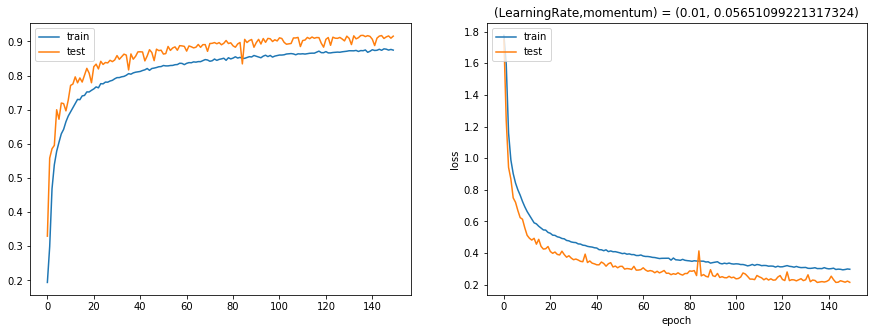

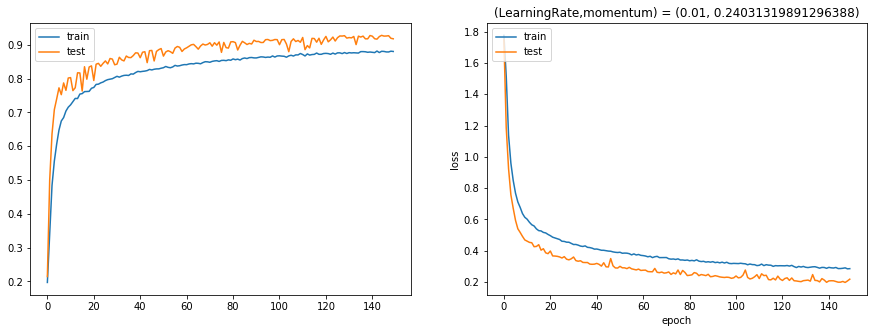

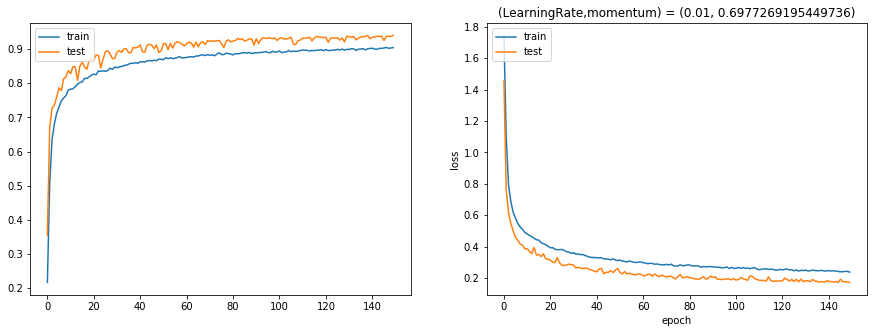

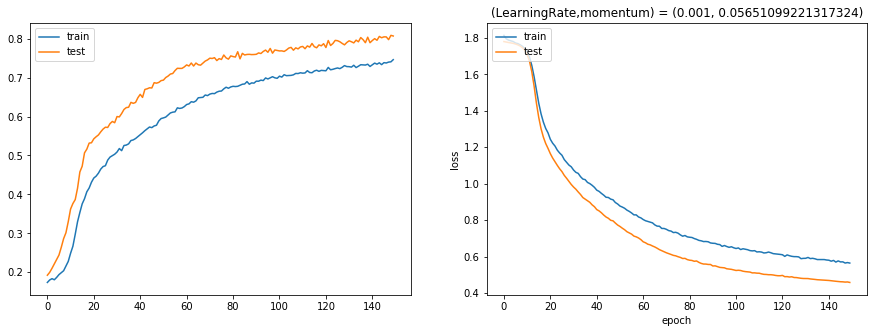

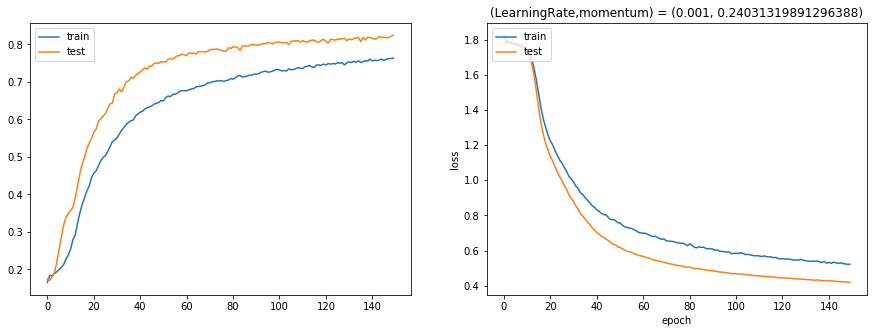

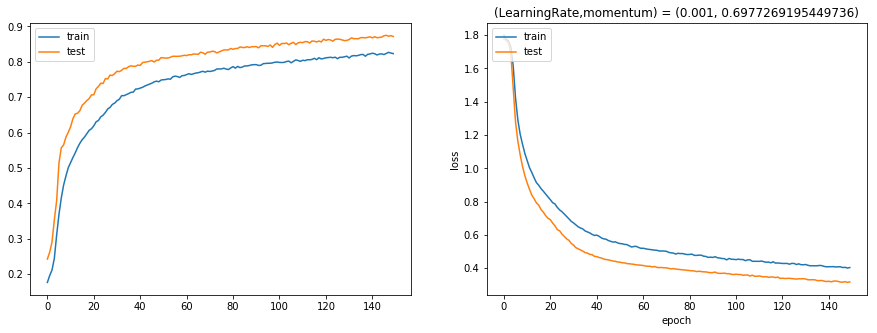

In [121]:
PlotLossAcc(load_res,search_grid)

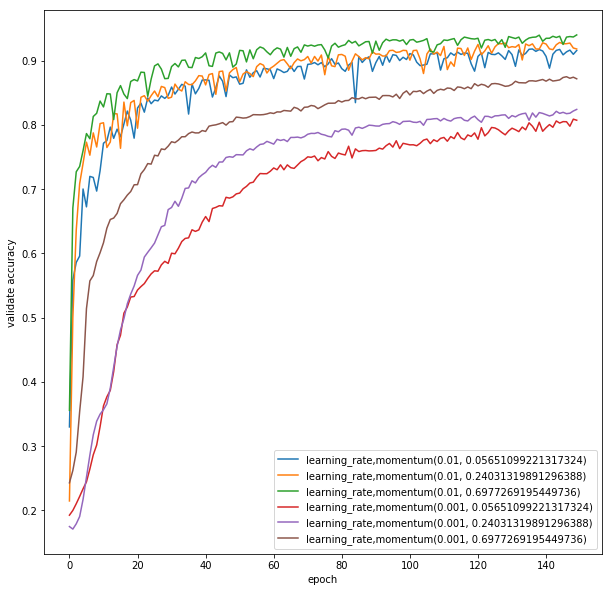

In [143]:
plt.figure(figsize=(10,10))

for j in range(len(search_grid)):
    plt.plot(load_res[j]['val_acc'],label="learning_rate,momentum"+str(search_grid[j]))
    plt.xlabel("epoch")
    plt.ylabel("validate accuracy")
    
plt.legend()

In [136]:
models[0].layers[13]

## Class Activation Map

In [137]:
def visualize_class_activation_map(model_path, img_path, output_path):
    #model = load_model(model_path)
    model=model_path
    #original_img = img_to_array(load_img(img_path, grayscale = True))
    original_img=img_path
    width, height, _ = original_img.shape

    #Reshape to the network input shape (3, w, h).
    #img = np.array([np.transpose(np.float32(original_img), (0, 1,2))])
    img = np.array([np.transpose(np.float32(original_img), (0, 1,2))])
        
    #Get the 512 input weights to the softmax.
    class_weights = model.layers[-2].get_weights()[0]
    #final_conv_layer = get_output_layer(model, "conv5_3")
    final_conv_layer = model.layers[13]   #because final convolutional layer is the 14th layer
    get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    imglist=[]
    imglist.append(img)
    [conv_outputs, predictions] = get_output(imglist)
    conv_outputs = conv_outputs[0, :, :, :]

    #Create the class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    target_class = 0
    for i, w in enumerate(class_weights[:,target_class]):
        cam += w * conv_outputs[:, :, i] # i th channel * w_i
    print(predictions)
    cam /= np.max(cam)
    cam = cv2.resize(cam, (height, width))
    #heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap=np.uint8(255*cam)
    heatmap[np.where(cam < 0.2)] = 0
    #original= cv2.applyColorMap(np.uint8(255*(np.max(original_img)-original_img)/(np.max(original_img)-np.min(original_img))), 
                                         #cv2.COLORMAP_BONE)
    original=255*(np.max(original_img)-original_img)/(np.max(original_img)-np.min(original_img))
    
    f, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(np.reshape(original_img,(64,64)),cmap = 'gray')
    ax1.set_title('Original image')
    #ax2.imshow(heatmap)
    ax2.imshow(heatmap, cmap = 'jet')
    ax2.imshow(np.reshape(original,(64,64)), cmap = 'gray', alpha = 0.5)
    #ax2.set_title('Original image + CAM \n Class: ' + defect_type)

    #print('defect type:', defect_type)
    #img = original_img
    #cv2.imwrite(output_path, img)

In [151]:
original_img=x_test_origin[2]
np.std(255*(np.max(original_img)-original_img)/(np.max(original_img)-np.min(original_img)))

114.40049

In [141]:
y_test_origin[1]

array([0., 0., 0., 0., 1., 0.], dtype=float32)

[[0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 1. 0.]]
[[0. 0. 0. 0. 1. 0.]]
[[2.0452779e-16 5.1598175e-12 0.0000000e+00 1.4048324e-19 1.0000000e+00
  0.0000000e+00]]
[[2.8517006e-12 2.2311641e-01 3.8977583e-13 6.4101989e-08 1.1788262e-12
  7.7688354e-01]]
[[0. 0. 0. 0. 1. 0.]]


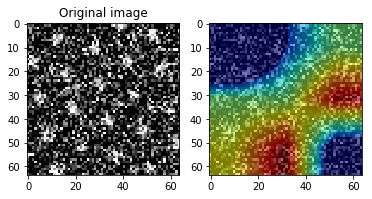

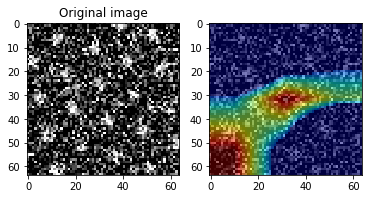

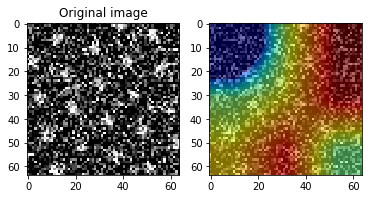

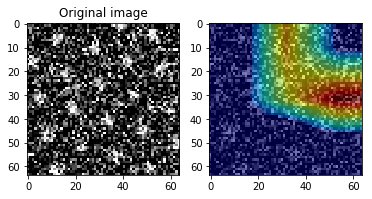

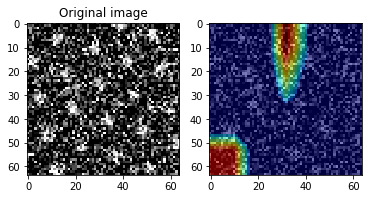

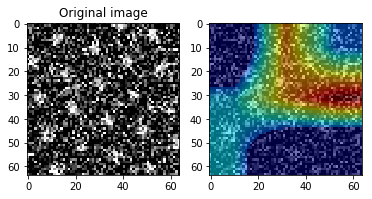

In [139]:
models_grid=[]

for j in range(len(search_grid)):
    models_grid.append(load_model('../HyperparametersTuning/0.2dropout_momentum1/model'+str(j)+'.h5'))
    visualize_class_activation_map(models_grid[-1], x_test_origin[1],
                                    "./heatmap/"+str(learn_rate[j])+".png")

In [13]:
learn_rate

[0.0012124478608052265,
 0.14065898274722327,
 0.4970479001357962,
 0.0011132905970441058,
 0.0005437384201377625,
 0.00111245571558223,
 0.010292057196606396,
 0.282838650784522,
 0.24036631698188757,
 8.120783460079087e-05,
 8.788437862948488e-05,
 1.787798599113689e-05,
 0.0026247429176293924,
 0.045978480262674426,
 0.022306480345392014]

In [27]:
for i in range(len(model.layers)):
    j=len(model.layers)-i-1
    if "activation_4" in model.layers[j].get_config()['name']:
        final_conv_layer=model.layers[j]
        print(j)
        break
    

10


## Prediction Validation

In [15]:
# load the experimental data
expdata=np.load("defect_list10.npy")

In [153]:
#expdata=expdata.reshape(expdata.shape[0],img_x,img_y,1)

In [16]:
#imgsrc=expdata[0]
imgsrc=x_test[2].reshape(64,64)


# 1/ratio of the radius of the mask to the original image in pixels
maskratio = 10

def FFTmask(imgsrc, maskratio=10):
    """Takes a square real space image and filter out a disk with radius equal to:
    1/maskratio * image size.
    Retruns FFT transform of the image and the filtered FFT transform
    """
    # Take the fourier transform of the image.
    F1 = fftpack.fft2((imgsrc)) 
    # Now shift so that low spatial frequencies are in the center.
    F2 = (fftpack.fftshift((F1)))
    # copy the array and zero out the center
    F3 = F2.copy()
    l = int(imgsrc.shape[0]/maskratio)
    m = int(imgsrc.shape[0]/2)
    y,x = np.ogrid[1: 2*l + 1, 1:2*l + 1]
    mask = (x - l)*(x - l) + (y - l)*(y - l) <= l*l
    F3[m-l:m+l, m-l:m+l] = F3[m-l:m+l, m-l:m+l] * (1 - mask)
    
    return F2, F3

F2, F3 = FFTmask(imgsrc, maskratio)

In [17]:
def FFTsub(imgsrc, F3):
    """Takes real space image and filtred FFT.
    Reconstructs real space image and subtracts it from the original.
    Returns normalized image. 
    """
    reconstruction = np.real(fftpack.ifft2(fftpack.ifftshift(F3)))
    diff = np.abs(imgsrc - reconstruction)
    
    #normalization
    diff = diff - np.amin(diff)
    diff = diff/np.amax(diff)
    
    return diff

In [18]:
diff = FFTsub(imgsrc, F3)
diff.shape

(64, 64)

In [19]:
def threshImg(diff, threshL=0.25, threshH=0.75):
    """Takes in difference image, low and high thresold values, and outputs a map of all defects.
    """
    
    threshIL = diff < threshL  
    threshIH = diff > threshH
    threshI = threshIL + threshIH
    
    return threshI

In [20]:
threshL = 0.25
threshH = 0.75

(-0.5, 63.5, 63.5, -0.5)

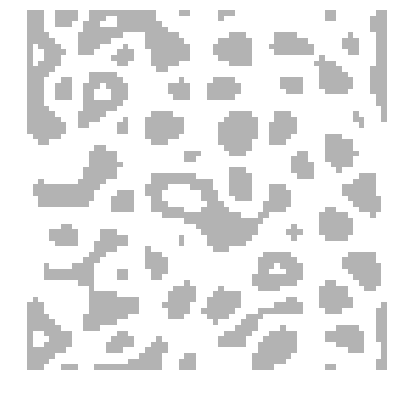

In [24]:
fig104 = plt.figure(104, figsize=(5,5))
ax = fig104.add_axes([0, 0, 1, 1])

threshI = threshImg(diff, threshL, threshH)

#ax.imshow(imgsrc)
#ax.imshow(threshI, cmap='coolwarm', alpha=0.3)
ax.imshow(threshI,cmap="gray", alpha=0.3)
ax.axis('off')